In [58]:
import numpy as np
import os
import yaml
import pandas as pd
import copy

from matplotlib.lines import Line2D

from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Metrics

In [59]:
def reduce_probs(probs):
    if len(probs.shape) == 3:
        return probs.mean(axis=1)
    return probs


def get_accuracy(probs, labels):
    probs = reduce_probs(probs)
    preds = np.argmax(probs, axis=-1)
    if len(preds) > len(labels):
        preds = preds[:len(labels)]
        print("Truncating preds")
    assert preds.shape == labels.shape
    return (preds == labels).mean()


def get_nll(probs, labels, normalized=True):
    probs = reduce_probs(probs)
    if len(probs) > len(labels):
        probs = probs[:len(labels)]
        print("Truncating preds")
    idx = (np.arange(labels.size), labels)
    log_ps = np.log(probs[idx])
    if normalized:
        return -log_ps.mean()
    else:
        return -log_ps.sum()

def get_calibration_curve(probs, labels, num_bins=20):
    probs = reduce_probs(probs)
    if len(probs) > len(labels):
        probs = probs[:len(labels)]
        print("Truncating preds")
    confidences = np.max(probs, 1)
    num_inputs = confidences.shape[0]
    step = (num_inputs + num_bins - 1) // num_bins
    bins = np.sort(confidences)[::step]
    if num_inputs % step != 1:
        bins = np.concatenate((bins, [np.max(confidences)]))
    predictions = np.argmax(probs, 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]

    accuracies = (predictions == labels)

    bin_confidences = []
    bin_accuracies = []
    bin_proportions = []

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) * (confidences < bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
            bin_confidences.append(avg_confidence_in_bin)
            bin_accuracies.append(accuracy_in_bin)
            bin_proportions.append(prop_in_bin)

    bin_confidences, bin_accuracies, bin_proportions = map(
      lambda lst: np.array(lst),
      (bin_confidences, bin_accuracies, bin_proportions))

    return {
      "confidence": bin_confidences,
      "accuracy": bin_accuracies,
      "proportions": bin_proportions,
      "ece": ece}


def get_entropy(probs):
    probs = reduce_probs(probs)
    entropy = -probs * np.log(probs)
    return entropy.sum(axis=1).mean(axis=0)

In [60]:
def get_kl(probs1, probs2):
    probs1 = reduce_probs(probs1)
    probs2 = reduce_probs(probs2)
    assert probs1.shape == probs2.shape
    kl = probs1 * np.log(probs1 / probs2)
    kl = kl.sum(axis=1).mean(axis=0)
    return kl


def get_sym_kl(probs1, probs2):
    kl = get_kl(probs1, probs2) + get_kl(probs2, probs1)
    return kl * 0.5


def get_prediction_matching(probs1, probs2):
    probs1 = reduce_probs(probs1)
    probs2 = reduce_probs(probs2)
    assert probs1.shape == probs2.shape
    preds1 = np.argmax(probs1, axis=-1)
    preds2 = np.argmax(probs2, axis=-1)
    return (preds1 == preds2).mean()

## File traversal

In [90]:
def is_leaf_directory(path):
    return all([file in os.listdir(path) for file in ["teacher_probs.npz", "student_probs.npz"]])


def process_all_subdirectories(path, process_leaf_directory, results_dict):
    if not os.path.isdir(path):
        return 
    if is_leaf_directory(path):
        process_leaf_directory(path, results_dict)
        return
    for subdir in os.listdir(path):
        full_path = os.path.join(path, subdir)
        process_all_subdirectories(full_path, process_leaf_directory, results_dict)
        

def get_config(path):
    path1 = os.path.join(path, "hydra_config.txt")
    path2 = os.path.join(path, ".hydra/config.yaml")
    if os.path.exists(path1):
        path = path1
    else:
        path = path2
    with open(path, "rb") as f:
        config = yaml.full_load(f)
    return config

In [91]:
def make_process_leaf_directory(performance_metrics, agreement_metrics):
    def process_leaf_directory(path, results_dict):
        print("Pocessing {}".format(path))

        config = get_config(path)

        teacher_probs_arr = np.load(os.path.join(path, "teacher_probs.npz"))
        student_probs_arr = np.load(os.path.join(path, "student_probs.npz"))
        transforms_list = config["augmentation"]["transforms_list"]
        mixup_used = False
        mixup_alpha = 0.
        if "mixup" in config:
            mixup_alpha = config["mixup"]["alpha"]
            mixup_used = mixup_alpha > 0
        if isinstance(transforms_list, list):
            transforms_list = ",".join(transforms_list)
        exp_description = {
            "teacher_depth": config['teacher']['depth'],
            "teacher_num_components": config['teacher']['num_components'],
            "classifier_depth": config['classifier']['depth'],
            "augmentations": transforms_list,
            "temperature": config["loss"]["init"]["temp"],
            "mixup_used": mixup_used,
            "mixup_alpha": mixup_alpha
        }
        results_dict[hash(path)] = {
            "exp_description": exp_description,
            "trial_id": config["trial_id"]
        }

        for probs, model in [[teacher_probs_arr, "teacher"], [student_probs_arr, "student"]]:
            for split in ["train", "test"]:
                for aug in ["aug_", ""]:
                    for metric_name, metric_fn in performance_metrics.items():
                        results_dict[hash(path)]["{}_{}{}_{}".format(model, aug, split, metric_name)] = \
                            metric_fn(probs["{}{}_probs".format(aug, split)], probs["{}_labels".format(split)])

        for split in ["train", "test"]:
            for aug in ["aug_", ""]:
                for metric_name, metric_fn in agreement_metrics.items():
                    results_dict[hash(path)]["{}{}_{}".format(aug, split, metric_name)] = \
                        metric_fn(teacher_probs_arr["{}{}_probs".format(aug, split)], 
                                  student_probs_arr["{}{}_probs".format(aug, split)])
        return
    return process_leaf_directory

In [92]:
def convert_dict_to_df(results_dict):
    df = None
    for i, (_, results) in enumerate(results_dict.items()):
        if df is None:
            df = pd.DataFrame(results, index=[i])
        else:
            df = df.append(pd.DataFrame(results, index=[i]))
    return df

In [93]:
def compute_baseline_vals(results_dict, agreement_metrics):
    for _, run in results_dict.items():
        trial_id = run["trial_id"]
        run["num_baselines"] = 0
        for _, other_run in results_dict.items():
            if (run["exp_description"] == other_run["exp_description"]) \
                and (run["trial_id"] != other_run["trial_id"]):
                run["num_baselines"] += 1
                for split in ["train", "test"]:
                    for aug in ["aug_", ""]:
                        for metric_name, metric_fn in agreement_metrics.items():
                            col_name = "baseline_{}{}_{}".format(aug, split, metric_name)
                            metric_val = metric_fn(run["teacher_{}{}_probs".format(aug, split)], 
                                          other_run["student_{}{}_probs".format(aug, split)])
                            
                            if col_name in run:
                                run[col_name] += (metric_val - run[col_name]) / run["num_baselines"]
                            else:
                                run[col_name] = metric_val
                                
    #post-processing
    for _, run in results_dict.items():
        probs_keys = [key for key in run if "probs" in key]
        for key in probs_keys:
            del run[key]
    
    for _, run in results_dict.items():
        for key, value in run["exp_description"].items():
            run[key] = value
    
        del run["exp_description"]

## Baseline distillation

In [65]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
#     "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p, 
    "entropy": lambda p, _: get_entropy(p),
}

agreement_metrics = {
    "kl_ts": get_kl,
#     "kl_st": lambda t, s: get_kl(s, t),
#     "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

In [66]:
base_dir = "../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
results_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_1/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_3/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_2/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet20_5-preresnet20_1/trial_1/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet20_5-preresnet20_1/trial_3/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillati

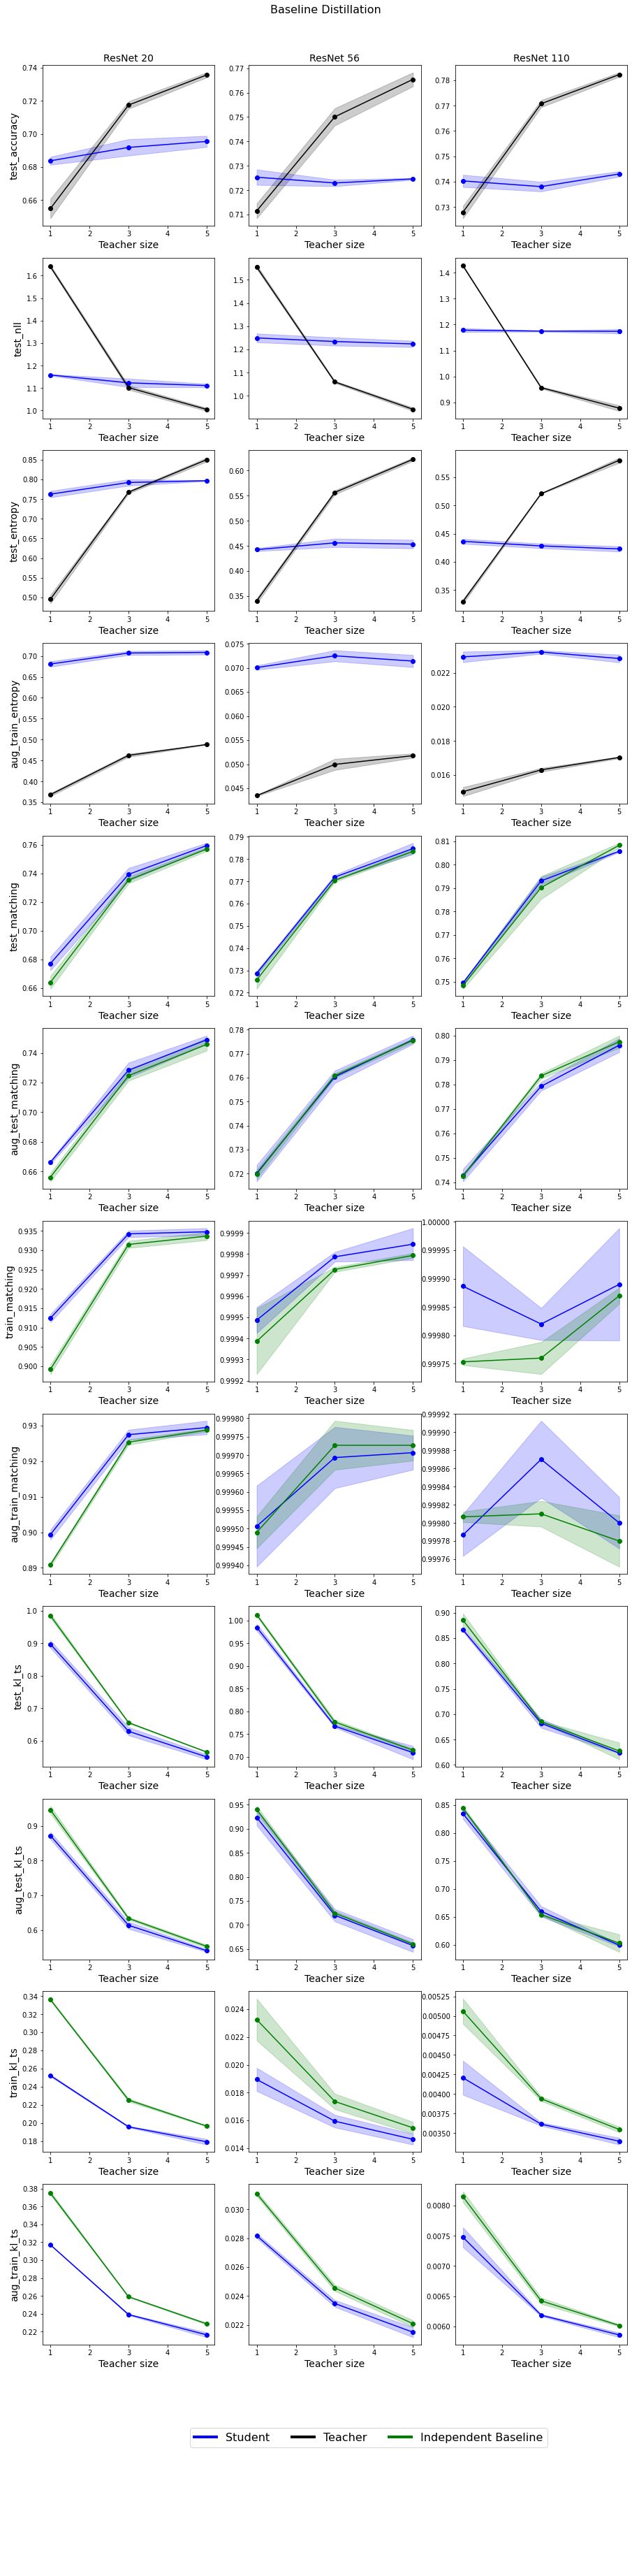

In [12]:

performance_metrics = ["test_accuracy", "test_nll", "test_entropy", "aug_train_entropy"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]
model_depths = [20, 56, 110]

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(model_depths)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

for j, teacher_depth in enumerate(model_depths):
    for i, metric in enumerate(performance_metrics):
        for model, color in [["student", "b"], ["teacher", "k"]]:
            mask = results_df["teacher_depth"]==teacher_depth
            mean = results_df[mask].groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
            std = results_df[mask].groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

            arr[i, j].plot(mean, "-o", color=color)
            arr[i, j].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
            arr[i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[i, 0].set_ylabel(metric, fontsize=14)
    for i, metric in enumerate(agreement_metrics):
        actual_i = i + len(performance_metrics)
        mask = results_df["teacher_depth"]==teacher_depth
        mean = results_df[mask].groupby("teacher_num_components").mean()
        std = results_df[mask].groupby("teacher_num_components").std()
        for model, color in [["", "b"], ["baseline_", "g"]]:
            actual_metric = "{}{}".format(model, metric)
            arr[actual_i, j].plot(mean[actual_metric], "-o", color=color)
            arr[actual_i, j].fill_between(
                mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
            arr[actual_i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[actual_i, 0].set_ylabel(metric, fontsize=14)
    arr[0, j].set_title("ResNet {}".format(teacher_depth), fontsize=14)

plt.suptitle("Baseline Distillation", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.3, 0.05))

### Individual predictions

In [15]:
for _, run in results_dict.items():
    if run["exp_description"]["teacher_num_components"] == 5 and \
       run["exp_description"]["classifier_depth"] == 20:
        break

In [18]:
teacher_probs = run["teacher_aug_train_probs"]
student_probs = run["student_aug_train_probs"]
teacher_probs = reduce_probs(teacher_probs)
teacher_confidences = np.max(teacher_probs, axis=1)
idx = np.argsort(teacher_confidences)

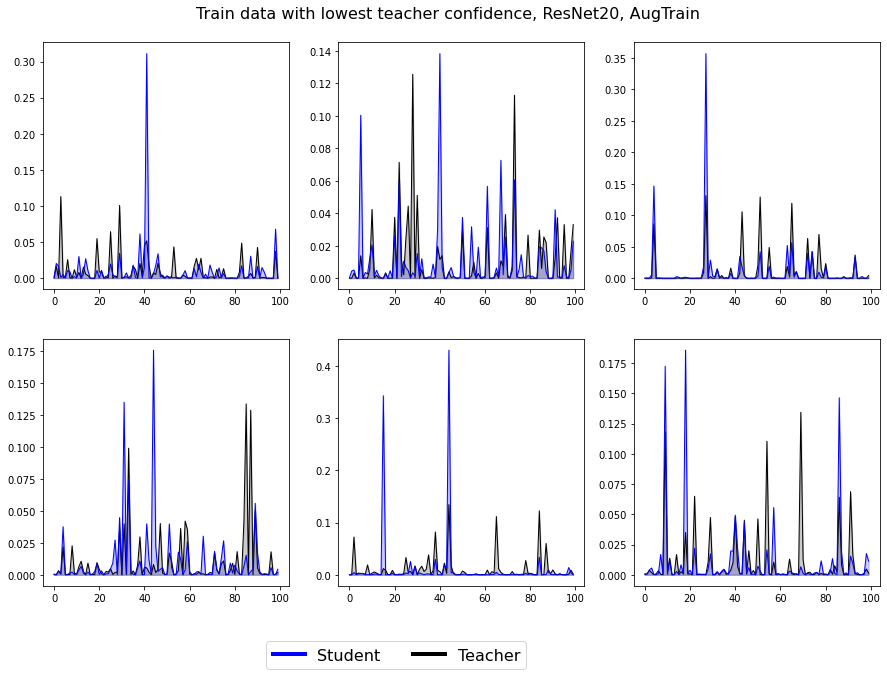

In [44]:
nrows, ncols = 2, 3
f, arr = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for i in range(nrows):
    for j in range(ncols):
        arr[i, j].plot(teacher_probs[idx[i*ncols + j]], color="k", lw=1)
        arr[i, j].plot(student_probs[idx[i*ncols + j]], color="b", lw=1)
        arr[i, j].fill_between(range(100), student_probs[idx[i*ncols + j]], 
                               color="b", alpha=0.2)
        arr[i, j].fill_between(range(100), teacher_probs[idx[i*ncols + j]], 
                               color="k", alpha=0.2)
        
plt.suptitle("Train data with lowest teacher confidence, ResNet20, AugTrain", fontsize=16, y=0.93)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)]
f.legend(custom_lines, ['Student', 'Teacher'], fontsize=16, ncol=3, loc=(0.3, 0.01))

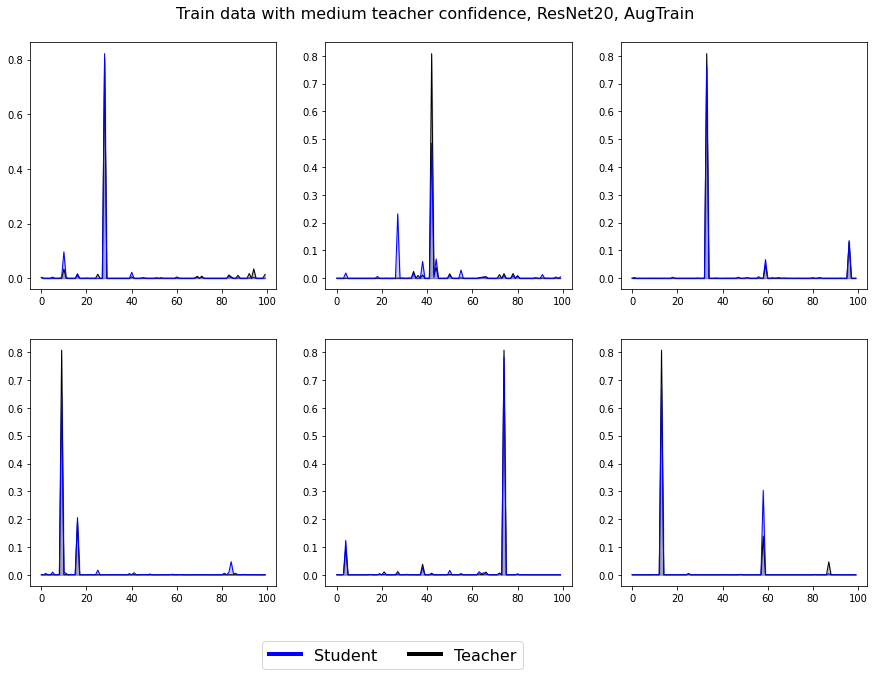

In [42]:
nrows, ncols = 2, 3
f, arr = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for i in range(nrows):
    for j in range(ncols):
        arr[i, j].plot(teacher_probs[idx[i*ncols + j + len(idx) // 4]], color="k", lw=1)
        arr[i, j].plot(student_probs[idx[i*ncols + j + len(idx) // 4]], color="b", lw=1)
        arr[i, j].fill_between(range(100), student_probs[idx[i*ncols + j + len(idx) // 4]], 
                               color="b", alpha=0.2)
        arr[i, j].fill_between(range(100), teacher_probs[idx[i*ncols + j + len(idx) // 4]], 
                               color="k", alpha=0.2)
        
plt.suptitle("Train data with medium teacher confidence, ResNet20, AugTrain", fontsize=16, y=0.93)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)]
f.legend(custom_lines, ['Student', 'Teacher'], fontsize=16, ncol=3, loc=(0.3, 0.01))

In [45]:
del results_dict

## Architecture cross-over

In [284]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
#     "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p,
    "entropy": lambda p, _: get_entropy(p),
}

agreement_metrics = {
    "kl_ts": get_kl,
#     "kl_st": lambda t, s: get_kl(s, t),
#     "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

base_dir = "../../gnosis_checkpoints/architecture_crossover_300epochs/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
results_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_1/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_3/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_2/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet20_3-preresnet56_1/trial_1/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet20_3-preresnet56_1/trial_3/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_

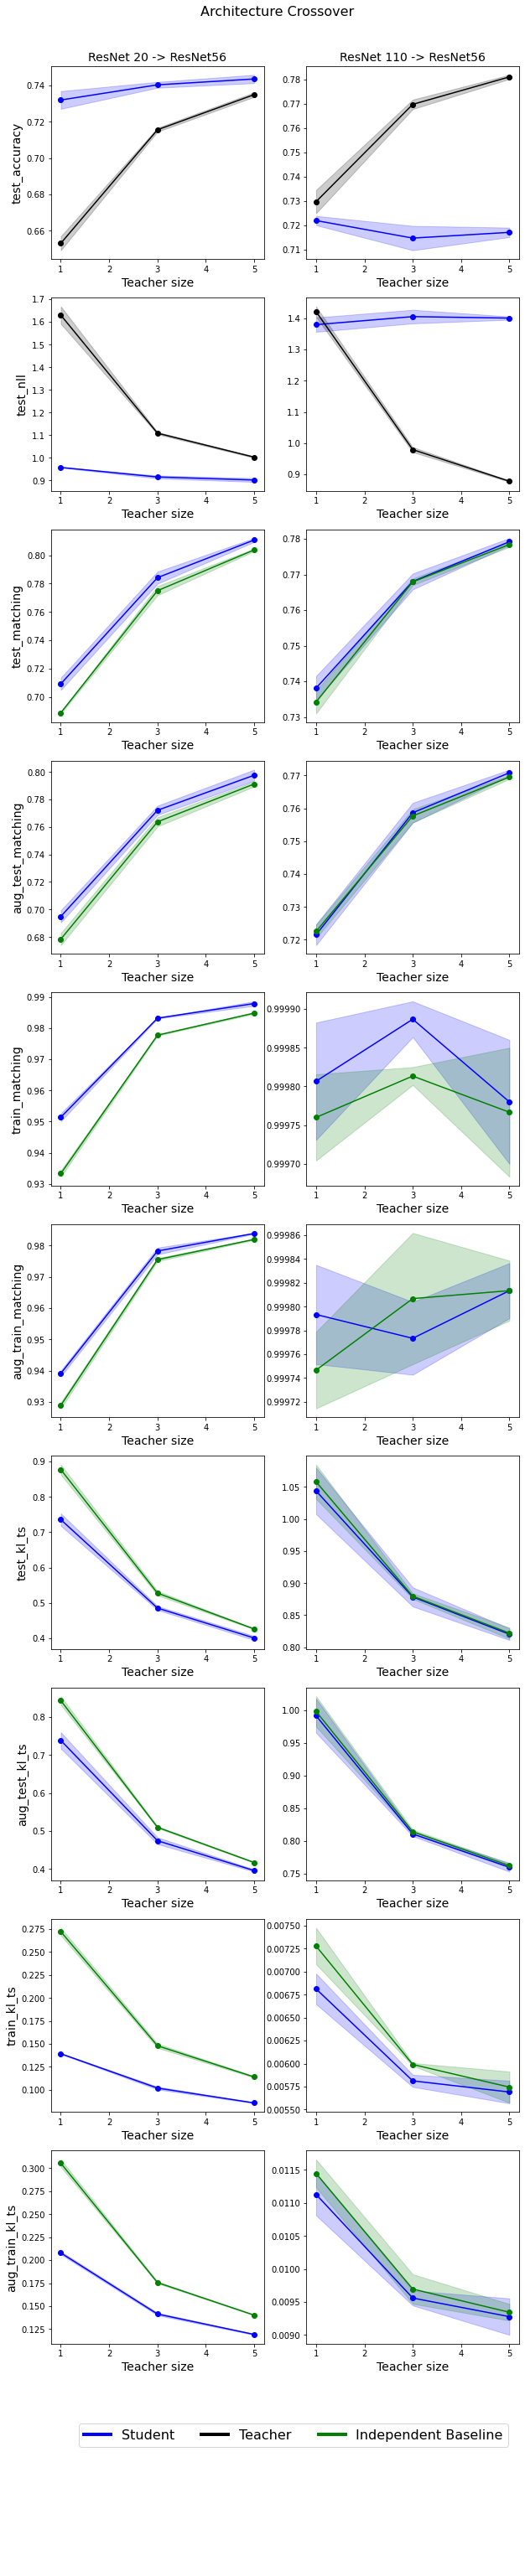

In [288]:
performance_metrics = ["test_accuracy", "test_nll"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]
model_depths = [20, 110]

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(model_depths)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

for j, teacher_depth in enumerate(model_depths):
    for i, metric in enumerate(performance_metrics):
        for model, color in [["student", "b"], ["teacher", "k"]]:
            mask = results_df["teacher_depth"]==teacher_depth
            mean = results_df[mask].groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
            std = results_df[mask].groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

            arr[i, j].plot(mean, "-o", color=color)
            arr[i, j].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
            arr[i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[i, 0].set_ylabel(metric, fontsize=14)
    for i, metric in enumerate(agreement_metrics):
        actual_i = i + len(performance_metrics)
        mask = results_df["teacher_depth"]==teacher_depth
        mean = results_df[mask].groupby("teacher_num_components").mean()
        std = results_df[mask].groupby("teacher_num_components").std()
        for model, color in [["", "b"], ["baseline_", "g"]]:
            actual_metric = "{}{}".format(model, metric)
            arr[actual_i, j].plot(mean[actual_metric], "-o", color=color)
            arr[actual_i, j].fill_between(
                mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
            arr[actual_i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[actual_i, 0].set_ylabel(metric, fontsize=14)
    arr[0, j].set_title("ResNet {} -> ResNet56".format(teacher_depth), fontsize=14)

plt.suptitle("Architecture Crossover", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.15, 0.05))

### Individual predictions

In [47]:
performance_metrics = {
    "probs": lambda p, _: p
}

agreement_metrics = {}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

base_dir = "../../gnosis_checkpoints/architecture_crossover_300epochs/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)

Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_1/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_3/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_2/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet20_3-preresnet56_1/trial_1/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet20_3-preresnet56_1/trial_3/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_

In [48]:
for _, run in results_dict.items():
    if run["exp_description"]["teacher_num_components"] == 5 and \
       run["exp_description"]["teacher_depth"] == 20:
        break

In [50]:
teacher_probs = run["teacher_aug_train_probs"]
student_probs = run["student_aug_train_probs"]
teacher_probs = reduce_probs(teacher_probs)
teacher_confidences = np.max(teacher_probs, axis=1)
idx = np.argsort(teacher_confidences)

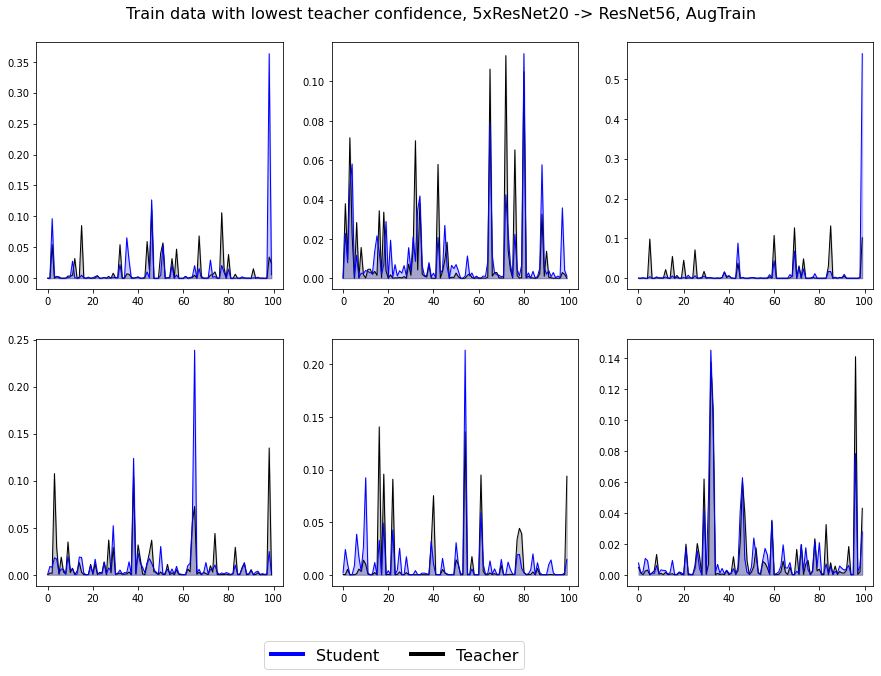

In [52]:
nrows, ncols = 2, 3
f, arr = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for i in range(nrows):
    for j in range(ncols):
        arr[i, j].plot(teacher_probs[idx[i*ncols + j]], color="k", lw=1)
        arr[i, j].plot(student_probs[idx[i*ncols + j]], color="b", lw=1)
        arr[i, j].fill_between(range(100), student_probs[idx[i*ncols + j]], 
                               color="b", alpha=0.2)
        arr[i, j].fill_between(range(100), teacher_probs[idx[i*ncols + j]], 
                               color="k", alpha=0.2)
        
plt.suptitle("Train data with lowest teacher confidence, 5xResNet20 -> ResNet56, AugTrain", fontsize=16, y=0.93)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)]
f.legend(custom_lines, ['Student', 'Teacher'], fontsize=16, ncol=3, loc=(0.3, 0.01))

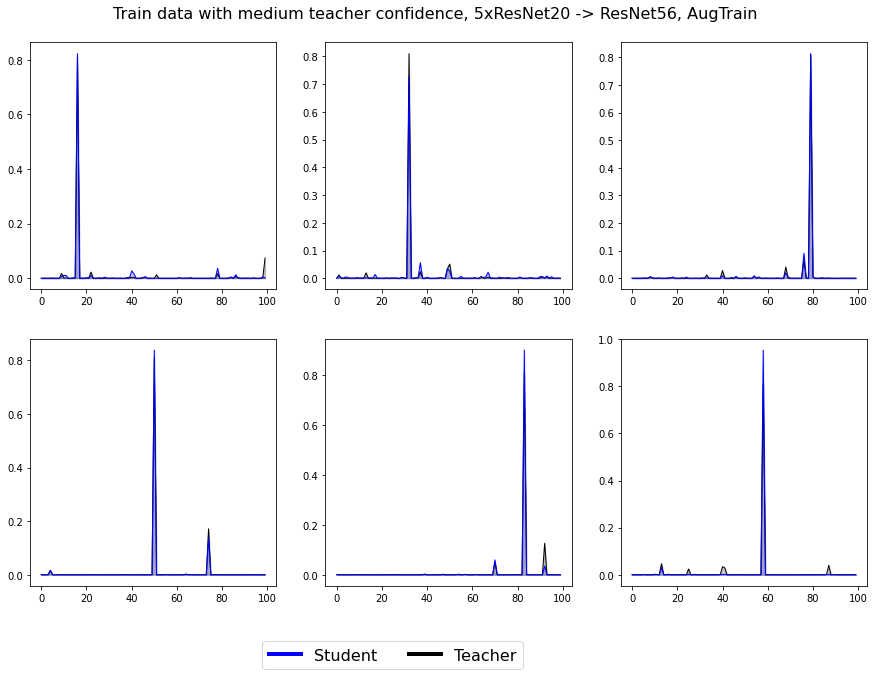

In [53]:
nrows, ncols = 2, 3
f, arr = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for i in range(nrows):
    for j in range(ncols):
        arr[i, j].plot(teacher_probs[idx[i*ncols + j + len(idx) // 4]], color="k", lw=1)
        arr[i, j].plot(student_probs[idx[i*ncols + j + len(idx) // 4]], color="b", lw=1)
        arr[i, j].fill_between(range(100), student_probs[idx[i*ncols + j + len(idx) // 4]], 
                               color="b", alpha=0.2)
        arr[i, j].fill_between(range(100), teacher_probs[idx[i*ncols + j + len(idx) // 4]], 
                               color="k", alpha=0.2)
        
plt.suptitle("Train data with medium teacher confidence, 5xResNet20 -> ResNet56, AugTrain", fontsize=16, y=0.93)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)]
f.legend(custom_lines, ['Student', 'Teacher'], fontsize=16, ncol=3, loc=(0.3, 0.01))

## MixUP

In [60]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
#     "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p, 
}

agreement_metrics = {
    "kl_ts": get_kl,
#     "kl_st": lambda t, s: get_kl(s, t),
#     "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

base_dir = "../../gnosis_checkpoints/mixup_300epochs/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
results_df = convert_dict_to_df(results_dict)



Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_3-preresnet56_1/trial_1/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_3-preresnet56_1/trial_3/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_3-preresnet56_1/trial_2/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_1-preresnet56_1/trial_1/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_1-preresnet56_1/trial_3/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_1-preresnet56_1/trial_2/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_

In [61]:
performance_metrics = ["test_accuracy", "test_nll"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]
model_depths = [56]

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(model_depths)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

teacher_depth = model_depths[0]
for i, metric in enumerate(performance_metrics):
    for model, color in [["student", "b"], ["teacher", "k"]]:
        mask = results_df["teacher_depth"]==teacher_depth
        mean = results_df[mask].groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
        std = results_df[mask].groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

        arr[i].plot(mean, "-o", color=color)
        arr[i].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
        arr[i].set_xlabel("Teacher size", fontsize=14)
    if j == 0:
        arr[i].set_ylabel(metric, fontsize=14)
for i, metric in enumerate(agreement_metrics):
    actual_i = i + len(performance_metrics)
    mask = results_df["teacher_depth"]==teacher_depth
    mean = results_df[mask].groupby("teacher_num_components").mean()
    std = results_df[mask].groupby("teacher_num_components").std()
    for model, color in [["", "b"], ["baseline_", "g"]]:
        actual_metric = "{}{}".format(model, metric)
        arr[actual_i].plot(mean[actual_metric], "-o", color=color)
        arr[actual_i].fill_between(
            mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
        arr[actual_i].set_xlabel("Teacher size", fontsize=14)
    arr[actual_i].set_ylabel(metric, fontsize=14)
arr[0].set_title("ResNet 56", fontsize=14)

plt.suptitle("MixUP Distillation", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.3, 0.05))

## SVHN augmentation

In [64]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
#     "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p, 
}

agreement_metrics = {
    "kl_ts": get_kl,
#     "kl_st": lambda t, s: get_kl(s, t),
#     "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

base_dir = "../../gnosis_checkpoints/svhn_augmentation/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
results_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/svhn_augmentation/synth_aug_0.0_cifar100_svhn_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_1/2021-01-22_22-59-20
Truncating preds
Truncating preds
Truncating preds
Truncating preds
Pocessing ../../gnosis_checkpoints/svhn_augmentation/synth_aug_0.0_cifar100_svhn_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_3/2021-01-22_22-59-20
Truncating preds
Truncating preds
Truncating preds
Truncating preds
Pocessing ../../gnosis_checkpoints/svhn_augmentation/synth_aug_0.0_cifar100_svhn_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_2/2021-01-22_22-59-20
Truncating preds
Truncating preds
Truncating preds
Truncating preds
Pocessing ../../gnosis_checkpoints/svhn_augmentation/synth_aug_0.0_cifar100_svhn_ts_soft_cross_ent_v0.0.10/preresnet56_1-preresnet56_1/trial_1/2021-01-22_22-59-20
Truncating preds
Truncating preds
Truncating preds
Truncating preds
Pocessing ../../gnosis_checkpoints/svhn_augmentation/synth_aug_0.0_cifar100_

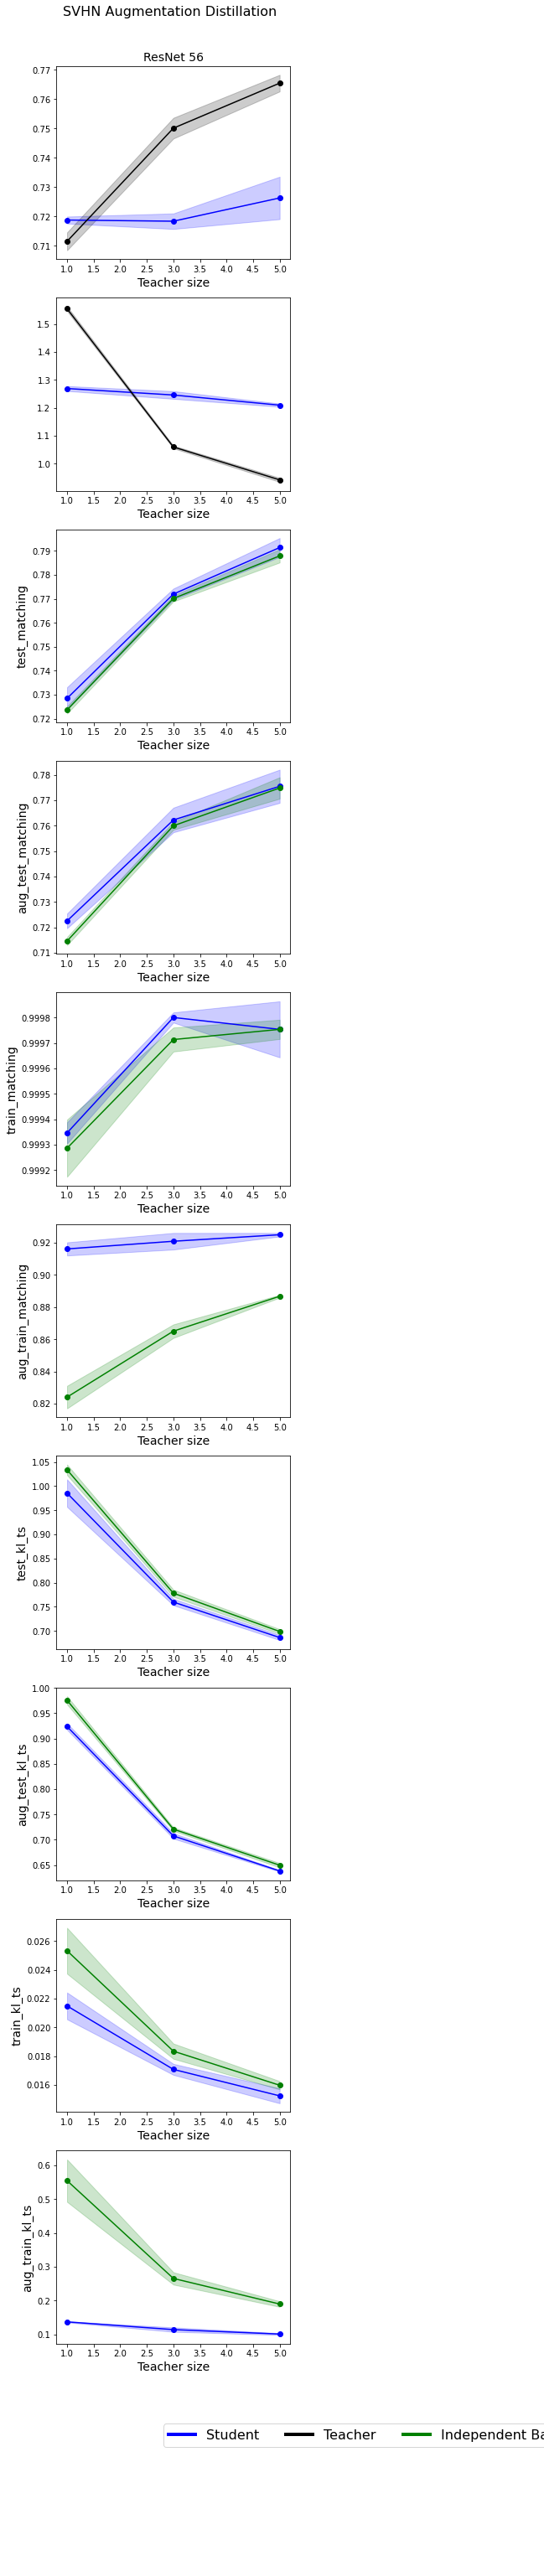

In [65]:
performance_metrics = ["test_accuracy", "test_nll"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]
model_depths = [56]

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(model_depths)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

teacher_depth = model_depths[0]
for i, metric in enumerate(performance_metrics):
    for model, color in [["student", "b"], ["teacher", "k"]]:
        mask = results_df["teacher_depth"]==teacher_depth
        mean = results_df[mask].groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
        std = results_df[mask].groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

        arr[i].plot(mean, "-o", color=color)
        arr[i].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
        arr[i].set_xlabel("Teacher size", fontsize=14)
    if j == 0:
        arr[i].set_ylabel(metric, fontsize=14)
for i, metric in enumerate(agreement_metrics):
    actual_i = i + len(performance_metrics)
    mask = results_df["teacher_depth"]==teacher_depth
    mean = results_df[mask].groupby("teacher_num_components").mean()
    std = results_df[mask].groupby("teacher_num_components").std()
    for model, color in [["", "b"], ["baseline_", "g"]]:
        actual_metric = "{}{}".format(model, metric)
        arr[actual_i].plot(mean[actual_metric], "-o", color=color)
        arr[actual_i].fill_between(
            mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
        arr[actual_i].set_xlabel("Teacher size", fontsize=14)
    arr[actual_i].set_ylabel(metric, fontsize=14)
arr[0].set_title("ResNet 56", fontsize=14)

plt.suptitle("SVHN Augmentation Distillation", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.3, 0.05))

In [67]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
#     "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p, 
}

agreement_metrics = {
    "kl_ts": get_kl,
#     "kl_st": lambda t, s: get_kl(s, t),
#     "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

base_dir = "../../gnosis_checkpoints/uniform_inputs//"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
results_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/uniform_inputs//synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/['replace_with_uniform']_0.2/preresnet56_3-preresnet56_1/trial_1/2021-01-24_02-20-16
Pocessing ../../gnosis_checkpoints/uniform_inputs//synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/['replace_with_uniform']_0.2/preresnet56_3-preresnet56_1/trial_2/2021-01-24_02-20-16
Pocessing ../../gnosis_checkpoints/uniform_inputs//synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/['replace_with_uniform']_0.2/preresnet56_3-preresnet56_1/trial_0/2021-01-24_02-20-16
Pocessing ../../gnosis_checkpoints/uniform_inputs//synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/['replace_with_uniform']_0.2/preresnet56_1-preresnet56_1/trial_1/2021-01-24_02-20-16
Pocessing ../../gnosis_checkpoints/uniform_inputs//synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/['replace_with_uniform']_0.2/preresnet56_1-preresnet56_1/trial_2/2021-01-24_02-20-16
Pocessing ../../gnosis_ch

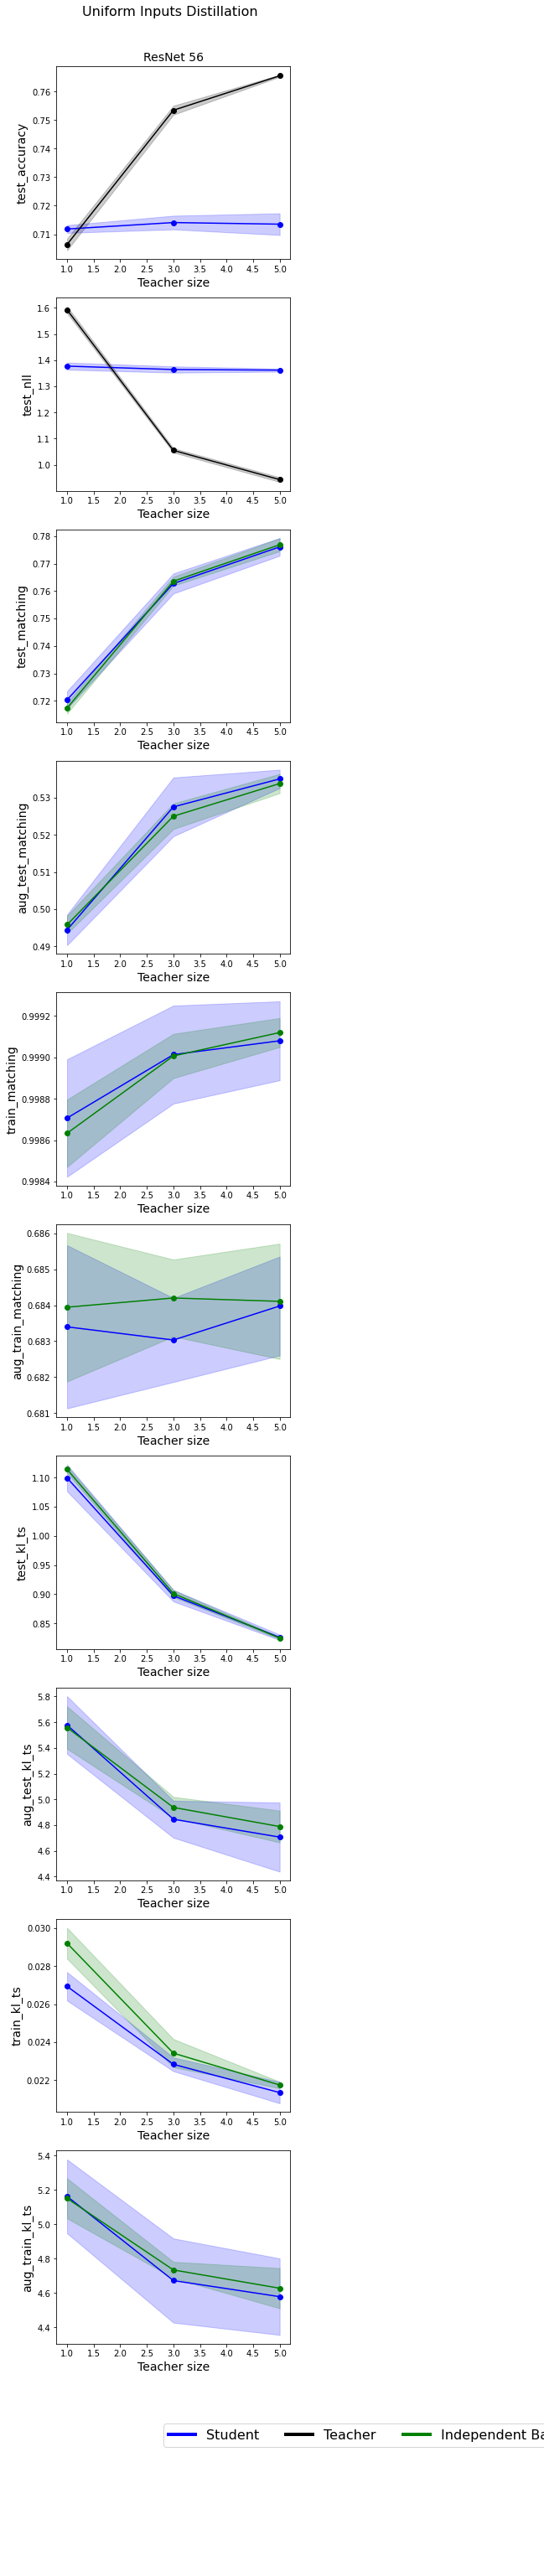

In [69]:
performance_metrics = ["test_accuracy", "test_nll"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]
model_depths = [56]

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(model_depths)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

teacher_depth = model_depths[0]
for i, metric in enumerate(performance_metrics):
    for model, color in [["student", "b"], ["teacher", "k"]]:
        mask = results_df["teacher_depth"]==teacher_depth
        mean = results_df[mask].groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
        std = results_df[mask].groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

        arr[i].plot(mean, "-o", color=color)
        arr[i].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
        arr[i].set_xlabel("Teacher size", fontsize=14)

    arr[i].set_ylabel(metric, fontsize=14)
for i, metric in enumerate(agreement_metrics):
    actual_i = i + len(performance_metrics)
    mask = results_df["teacher_depth"]==teacher_depth
    mean = results_df[mask].groupby("teacher_num_components").mean()
    std = results_df[mask].groupby("teacher_num_components").std()
    for model, color in [["", "b"], ["baseline_", "g"]]:
        actual_metric = "{}{}".format(model, metric)
        arr[actual_i].plot(mean[actual_metric], "-o", color=color)
        arr[actual_i].fill_between(
            mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
        arr[actual_i].set_xlabel("Teacher size", fontsize=14)
    arr[actual_i].set_ylabel(metric, fontsize=14)
arr[0].set_title("ResNet 56", fontsize=14)

plt.suptitle("Uniform Inputs Distillation", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.3, 0.05))

## Augmentation Ablation

In [73]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
#     "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p, 
}

agreement_metrics = {
    "kl_ts": get_kl,
#     "kl_st": lambda t, s: get_kl(s, t),
#     "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

base_dir = "../../gnosis_checkpoints/aug_ablation/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
results_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_1/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_3/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_2/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_1-preresnet56_1/trial_1/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_1-preresnet56_1/trial_3/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjit

In [77]:
performance_metrics = ["test_accuracy", "test_nll"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]

augmentations = ["colorjitter,crop,horizontal_flip", 
                 "vertical_flip,crop,horizontal_flip",
                 "rotation,crop,horizontal_flip",
                 "rotation,vertical_flip,colorjitter,crop,horizontal_flip"]

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(augmentations)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

teacher_depth = 56

for j, aug in enumerate(augmentations):
    for i, metric in enumerate(performance_metrics):
        for model, color in [["student", "b"], ["teacher", "k"]]:
            mask = results_df["augmentations"]==aug
            mean = results_df[mask].groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
            std = results_df[mask].groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

            arr[i, j].plot(mean, "-o", color=color)
            arr[i, j].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
            arr[i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[i, 0].set_ylabel(metric, fontsize=14)
    for i, metric in enumerate(agreement_metrics):
        actual_i = i + len(performance_metrics)
        mask = results_df["augmentations"]==aug
        mean = results_df[mask].groupby("teacher_num_components").mean()
        std = results_df[mask].groupby("teacher_num_components").std()
        for model, color in [["", "b"], ["baseline_", "g"]]:
            actual_metric = "{}{}".format(model, metric)
            arr[actual_i, j].plot(mean[actual_metric], "-o", color=color)
            arr[actual_i, j].fill_between(
                mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
            arr[actual_i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[actual_i, 0].set_ylabel(metric, fontsize=14)
    arr[0, j].set_title(aug, fontsize=14)

plt.suptitle("Augmentation Ablation, ResNet56", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.3, 0.05))

## Temperature ablation

In [27]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
    "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p, 
}

agreement_metrics = {
    "kl_ts": get_kl,
#     "kl_st": lambda t, s: get_kl(s, t),
#     "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}
process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

base_dir = "../../gnosis_checkpoints/temp_ablation/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
results_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_3-preresnet56_1/trial_1/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_3-preresnet56_1/trial_2/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_3-preresnet56_1/trial_0/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_1-preresnet56_1/trial_1/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_1-preresnet56_1/trial_2/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_1-preresnet56_1/trial_0/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_5-preresnet56_1/trial_1/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_a

In [47]:
results_df[results_df["temperature"] == 4.]["student_test_accuracy"]

0    0.7481
1    0.7460
2    0.7486
3    0.7412
4    0.7437
5    0.7439
6    0.7473
7    0.7485
8    0.7504
Name: student_test_accuracy, dtype: float64

In [56]:
results_df[results_df["temperature"] == 1.]["classifier_depth"]

18    110
19    110
20    110
21    110
22    110
23    110
24    110
25    110
26    110
Name: classifier_depth, dtype: int64

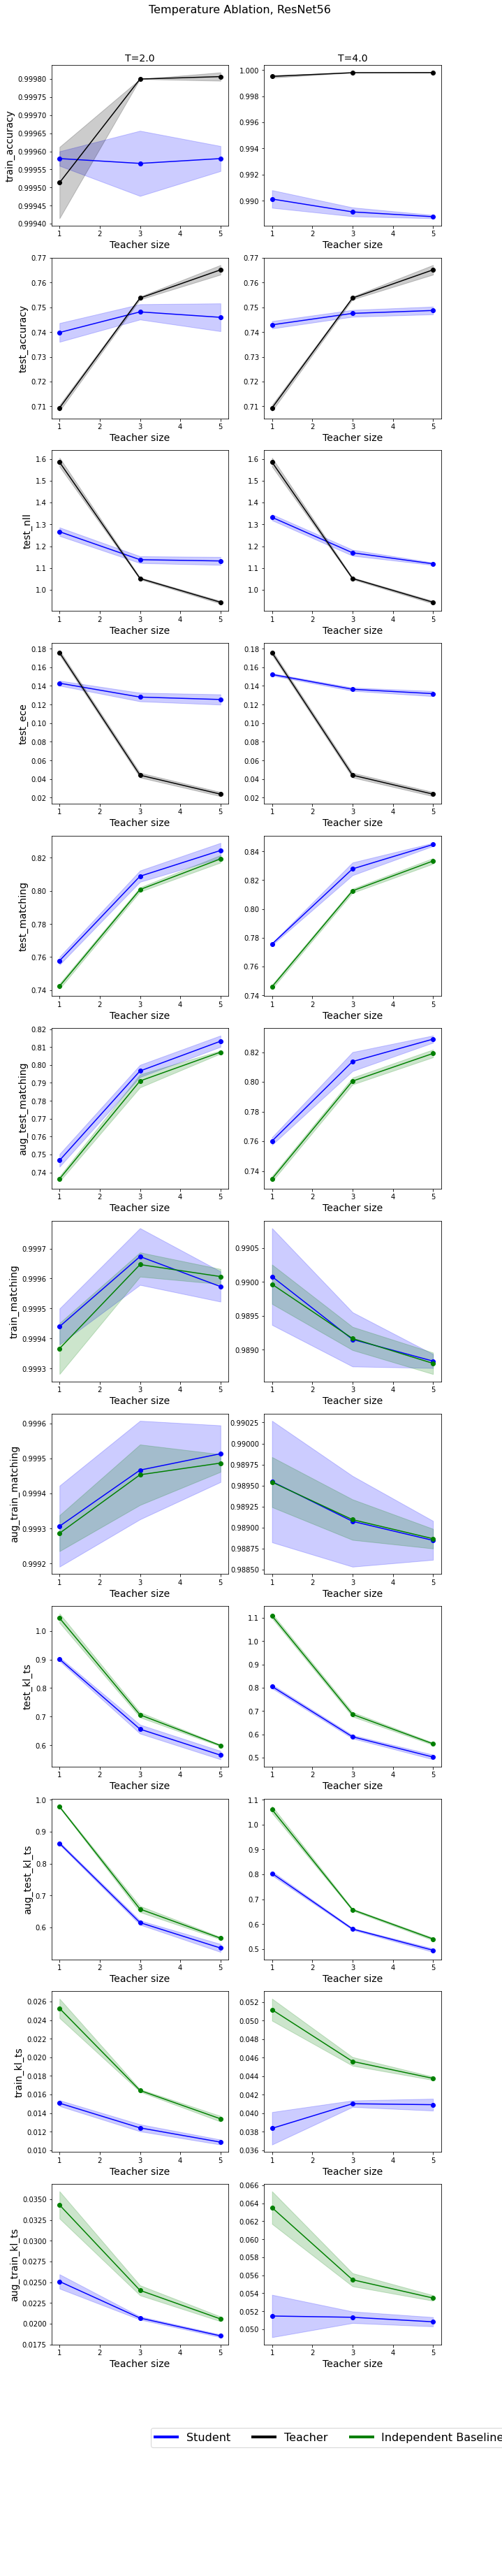

In [57]:
performance_metrics = ["train_accuracy", "test_accuracy", "test_nll", "test_ece"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]

temperatures = [2., 4.]

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(temperatures)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

teacher_depth = 56

for j, temperature in enumerate(temperatures):
    for i, metric in enumerate(performance_metrics):
        for model, color in [["student", "b"], ["teacher", "k"]]:
            mask = (results_df["temperature"]==temperature)
            mean = results_df[mask].groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
            std = results_df[mask].groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

            arr[i, j].plot(mean, "-o", color=color)
            arr[i, j].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
            arr[i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[i, 0].set_ylabel(metric, fontsize=14)
    for i, metric in enumerate(agreement_metrics):
        actual_i = i + len(performance_metrics)
        mask = results_df["temperature"]==temperature
        mean = results_df[mask].groupby("teacher_num_components").mean()
        std = results_df[mask].groupby("teacher_num_components").std()
        for model, color in [["", "b"], ["baseline_", "g"]]:
            actual_metric = "{}{}".format(model, metric)
            arr[actual_i, j].plot(mean[actual_metric], "-o", color=color)
            arr[actual_i, j].fill_between(
                mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
            arr[actual_i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[actual_i, 0].set_ylabel(metric, fontsize=14)
    arr[0, j].set_title("T={}".format(temperature), fontsize=14)

plt.suptitle("Temperature Ablation, ResNet56", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.3, 0.05))

In [55]:
path = "../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_1.0/preresnet56_5-preresnet56_1/trial_0/2021-01-18_04-21-35/student_train_metrics.csv"

## One big dataframe

In [94]:
performance_metrics = {
    "accuracy": get_accuracy,
    "nll": get_nll,
    "ece": lambda p, y: get_calibration_curve(p, y)["ece"],
    "probs": lambda p, _: p, 
}

agreement_metrics = {
    "kl_ts": get_kl,
    "kl_st": lambda t, s: get_kl(s, t),
    "sym_kl": get_sym_kl,
    "matching": get_prediction_matching
}

process_leaf_directory = make_process_leaf_directory(performance_metrics, agreement_metrics)

In [95]:
base_dir = "../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
baseline_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_1/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_3/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_2/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet20_5-preresnet20_1/trial_1/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet20_5-preresnet20_1/trial_3/2021-01-24_10-59-18
Pocessing ../../gnosis_checkpoints/pavel_baseline_distillati

In [96]:
base_dir = "../../gnosis_checkpoints/architecture_crossover_300epochs/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
teacher_crossover_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_1/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_3/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet110_3-preresnet56_1/trial_2/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet20_3-preresnet56_1/trial_1/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet20_3-preresnet56_1/trial_3/2021-01-24_18-15-54
Pocessing ../../gnosis_checkpoints/architecture_crossover_300epochs/synth_aug_0.0_

In [97]:
base_dir = "../../gnosis_checkpoints/mixup_300epochs/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
mixup_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_3-preresnet56_1/trial_1/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_3-preresnet56_1/trial_3/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_3-preresnet56_1/trial_2/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_1-preresnet56_1/trial_1/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_1-preresnet56_1/trial_3/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_v0.0.10/preresnet56_1-preresnet56_1/trial_2/2021-01-24_18-06-59
Pocessing ../../gnosis_checkpoints/mixup_300epochs/cifar100_ts_soft_cross_ent_alpha_0.0_

In [98]:
base_dir = "../../gnosis_checkpoints/aug_ablation/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
augmentation_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_1/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_3/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_3-preresnet56_1/trial_2/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_1-preresnet56_1/trial_1/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjitter,crop,horizontal_flip_cifar100_ts_soft_cross_ent_v0.0.10/preresnet56_1-preresnet56_1/trial_3/2021-01-22_14-42-46
Pocessing ../../gnosis_checkpoints/aug_ablation/augmentations_colorjit

In [99]:
base_dir = "../../gnosis_checkpoints/temp_ablation/"
results_dict = {}
process_all_subdirectories(base_dir, process_leaf_directory, results_dict)
compute_baseline_vals(results_dict, agreement_metrics)
temperature_df = convert_dict_to_df(results_dict)

Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_3-preresnet56_1/trial_1/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_3-preresnet56_1/trial_2/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_3-preresnet56_1/trial_0/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_1-preresnet56_1/trial_1/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_1-preresnet56_1/trial_2/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_1-preresnet56_1/trial_0/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_ablation/temp_ablation/cifar100_temp_4.0/preresnet56_5-preresnet56_1/trial_1/2021-01-26_21-39-42
Pocessing ../../gnosis_checkpoints/temp_a

In [100]:
big_df = baseline_df.append(teacher_crossover_df).append(mixup_df).append(augmentation_df).append(temperature_df).reset_index()
# big_df.to_csv("results_combined.csv")

## MixUP + Temperatures

In [107]:
import functools

In [101]:
big_df = pd.read_csv("results_combined.csv")

In [121]:
big_df["augmentations"].uniqueue()

array(['crop,horizontal_flip', 'colorjitter,crop,horizontal_flip',
       'vertical_flip,crop,horizontal_flip',
       'rotation,vertical_flip,colorjitter,crop,horizontal_flip',
       'rotation,crop,horizontal_flip'], dtype=object)

Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9
Number of trials: 9


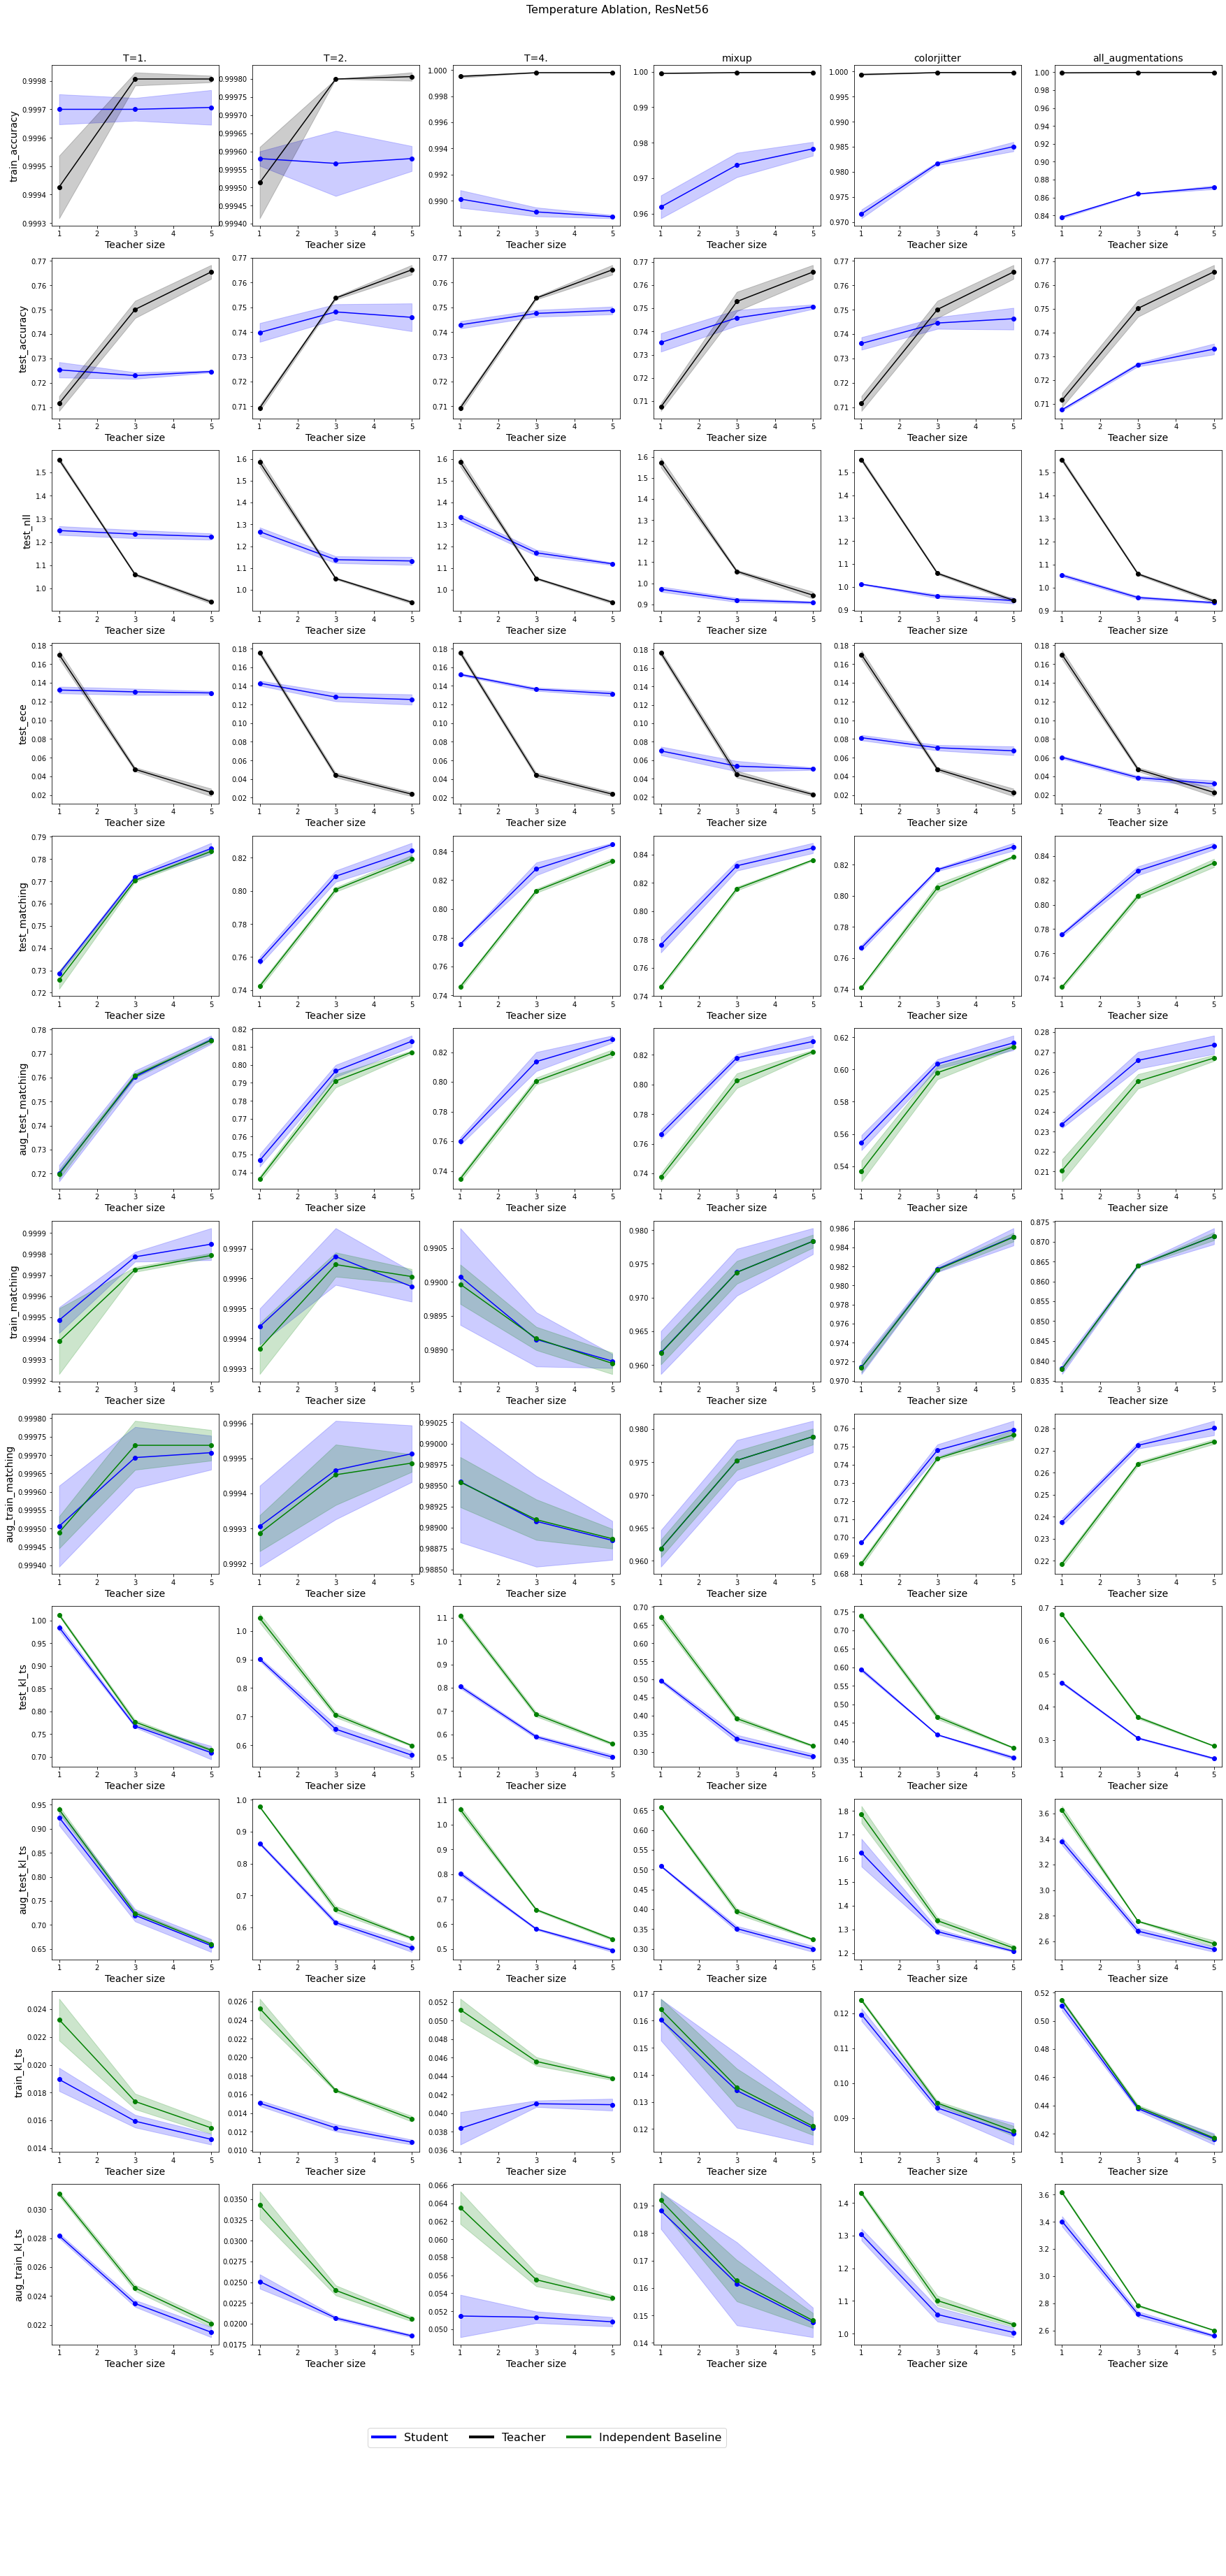

In [132]:
performance_metrics = ["train_accuracy", "test_accuracy", "test_nll", "test_ece"]
agreement_metrics = ["test_matching", "aug_test_matching", "train_matching", "aug_train_matching",
                     "test_kl_ts", "aug_test_kl_ts", "train_kl_ts", "aug_train_kl_ts"]


masks = {
    "T=1.": {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
    },
    "T=2.": {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 2.,
        "augmentations": "crop,horizontal_flip",
    },
    "T=4.": {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 4.,
        "augmentations": "crop,horizontal_flip",
    },
    "mixup": {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": True,
        "temperature": 1.,
        "augmentations": "crop,horizontal_flip",
    },
    "colorjitter": {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "colorjitter,crop,horizontal_flip",
    },
    "all_augmentations": {
        "teacher_depth": 56,
        "classifier_depth": 56,
        "mixup_used": False,
        "temperature": 1.,
        "augmentations": "rotation,vertical_flip,colorjitter,crop,horizontal_flip",
    }
}

n_rows = len(performance_metrics) + len(agreement_metrics)
n_cols = len(masks)
f, arr = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

for j, (exp_name, mask_dict) in enumerate(masks.items()):
    mask = functools.reduce(
        lambda a, b: a & b, [big_df[key] == value for key, value in mask_dict.items()],
        True)
    masked_results = big_df[mask]
    print("Number of trials:", len(masked_results))
    
    for i, metric in enumerate(performance_metrics):
        for model, color in [["student", "b"], ["teacher", "k"]]:
            
            mean = masked_results.groupby("teacher_num_components").mean()["{}_{}".format(model, metric)]
            std = masked_results.groupby("teacher_num_components").std()["{}_{}".format(model, metric)]

            arr[i, j].plot(mean, "-o", color=color)
            arr[i, j].fill_between(mean.index, mean+std, mean-std, color=color, alpha=0.2)
            arr[i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[i, 0].set_ylabel(metric, fontsize=14)
    for i, metric in enumerate(agreement_metrics):
        actual_i = i + len(performance_metrics)
        mean = masked_results.groupby("teacher_num_components").mean()
        std = masked_results.groupby("teacher_num_components").std()
        for model, color in [["", "b"], ["baseline_", "g"]]:
            actual_metric = "{}{}".format(model, metric)
            arr[actual_i, j].plot(mean[actual_metric], "-o", color=color)
            arr[actual_i, j].fill_between(
                mean.index, (mean+std)[actual_metric], (mean-std)[actual_metric], color=color, alpha=0.2)
            arr[actual_i, j].set_xlabel("Teacher size", fontsize=14)
        if j == 0:
            arr[actual_i, 0].set_ylabel(metric, fontsize=14)
    arr[0, j].set_title(exp_name, fontsize=14)

plt.suptitle("Temperature Ablation, ResNet56", fontsize=16, y=0.9)

custom_lines = [Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
                Line2D([0], [0], color="g", lw=4)]

f.legend(custom_lines, ['Student', 'Teacher', 'Independent Baseline'], fontsize=16, ncol=3, loc=(0.3, 0.05))

In [125]:
mask = functools.reduce(
        lambda a, b: a & b, [big_df[key] == value for key, value in masks["colorjitter"].items()],
        True
    )

In [126]:
mask.sum()

9

In [ ]:
#     "colorjitter": {
#         "teacher_depth": 56,
#         "classifier_depth": 56,
#         "mixup_used": False,
#         "temperature": 1.,
#         "augmentations": "colorjitter,crop,horizontal_flip",
#     }

In [127]:
big_df[mask]["teacher_depth"]

Unnamed: 0  index  trial_id  teacher_aug_train_accuracy  \
52          52      0         1                     0.82932   
53          53      1         3                     0.82480   
54          54      2         2                     0.82732   
55          55      3         1                     0.78030   
56          56      4         3                     0.77670   
57          57      5         2                     0.77632   
58          58      6         1                     0.83810   
59          59      7         3                     0.83600   
60          60      8         2                     0.83876   

    teacher_aug_train_nll  teacher_aug_train_ece  teacher_train_accuracy  \
52               0.771628               0.026456                 0.99978   
53               0.794746               0.023831                 0.99982   
54               0.790758               0.026178                 0.99982   
55               1.091401               0.089797                 0.99942   
56               1.107004               0.093521                 0.99932   
57               1.116997               0.094852                 0.99954   
58               0.718611               0.038520                 0.99982   
59               0.730633               0.035063                 0.99980   
60               0.719669               0.038370                 0.99980   

    teacher_train_nll  teacher_train_ece  teacher_aug_test_accuracy  ...  \
52           0.006376           0.005786                     0.6160  ...   
53           0.005997           0.005491                     0.6041  ...   
54           0.006101           0.005628                     0.6054  ...   
55           0.006689           0.005215                     0.5547  ...   
56           0.007191           0.005421                     0.5671  ...   
57           0.006281           0.005073                     0.5550  ...   
58           0.005989           0.005569                     0.6214  ...   
59           0.006258           0.005799                     0.6306  ...   
60           0.005934           0.005490                     0.6227  ...   

    baseline_test_kl_st  baseline_test_sym_kl  baseline_test_matching  \
52             0.520112              0.489471                 0.80825   
53             0.523936              0.496618                 0.80445   
54             0.517485              0.493620                 0.80305   
55             1.148314              0.946395                 0.74175   
56             1.133863              0.933845                 0.74120   
57             1.138842              0.940455                 0.74010   
58             0.389725              0.386620                 0.82585   
59             0.390061              0.385483                 0.82485   
60             0.386147              0.384587                 0.82445   

    teacher_depth  teacher_num_components  classifier_depth  \
52             56                       3                56   
53             56                       3                56   
54             56                       3                56   
55             56                       1                56   
56             56                       1                56   
57             56                       1                56   
58             56                       5                56   
59             56                       5                56   
60             56                       5                56   

                       augmentations  temperature  mixup_used  mixup_alpha  
52  colorjitter,crop,horizontal_flip          1.0       False          0.0  
53  colorjitter,crop,horizontal_flip          1.0       False          0.0  
54  colorjitter,crop,horizontal_flip          1.0       False          0.0  
55  colorjitter,crop,horizontal_flip          1.0       False          0.0  
56  colorjitter,crop,horizontal_flip          1.0       False          0.0  
57  colorjitter,crop,horizo

## Develop

In [101]:
list(mean+std)

[1.1859517634026808, 1.1772212260054737, 1.1822734084760684]

In [88]:
mean

teacher_num_components
1    1.178522
3    1.174955
5    1.174081
Name: student_test_nll, dtype: float32

In [75]:
mean_test_acc

teacher_num_components
1    0.74030
3    0.73805
5    0.74305
Name: student_test_accuracy, dtype: float64

In [43]:
for key, value in results_dict:
    

{41301433861227245: {'teacher_depth': 56,
  'teacher_num_components': 3,
  'classifier_depth': 56,
  'teacher_aug_train_accuracy': 0.99986,
  'teacher_train_accuracy': 0.99966,
  'teacher_aug_test_accuracy': 0.7266,
  'teacher_test_accuracy': 0.7216,
  'student_aug_train_accuracy': 0.99966,
  'student_train_accuracy': 0.99966,
  'student_aug_test_accuracy': 0.7216,
  'student_test_accuracy': 0.7216},
 -4335187565294210548: {'teacher_depth': 56,
  'teacher_num_components': 3,
  'classifier_depth': 56,
  'teacher_aug_train_accuracy': 0.99974,
  'teacher_train_accuracy': 0.99974,
  'teacher_aug_test_accuracy': 0.7244,
  'teacher_test_accuracy': 0.7243,
  'student_aug_train_accuracy': 0.9996,
  'student_train_accuracy': 0.99974,
  'student_aug_test_accuracy': 0.7197,
  'student_test_accuracy': 0.7243},
 -4316455981254362162: {'teacher_depth': 56,
  'teacher_num_components': 3,
  'classifier_depth': 56,
  'teacher_aug_train_accuracy': 0.99966,
  'teacher_train_accuracy': 0.9997,
  'teacher_

In [25]:
os.listdir("../../gnosis_checkpoints/pavel_baseline_distillation_soft_only_300epochs/synth_aug_0.0_cifar100_ts_soft_cross_ent_v0.0.10/preresnet20_3-preresnet20_1/trial_2/2021-01-24_10-59-18")

['student_probs.npz',
 'hydra_config.txt',
 'events.out.tfevents.1611514781.mint',
 'student_train_metrics.csv',
 'teacher_0.ckpt',
 'student.ckpt',
 'teacher_2.ckpt',
 '.hydra',
 'teacher_1.ckpt',
 'image_classification.log']